# 🧠 MLP Models for Drug Sensitivity Prediction

This notebook trains a **Multi-layer Perceptron (MLP)** regression model for each drug in the GDSC dataset using gene expression features (PCA or HVGs). Models are trained to predict `LN_IC50` values for each (cell line, drug) pair.

We use **5-fold cross-validation** to get stable metrics for each model.


In [14]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Choose your input dataset
DATA_PATH = "../../../data/bulk/bulk_drug_with_pca.parquet"

data = pd.read_parquet(DATA_PATH)
print("✅ Dataset loaded:", data.shape)

✅ Dataset loaded: (571985, 13)


### 🔁 Training One MLP per Drug

Each model is trained using **5-fold cross-validation** to estimate generalization performance.  
We record the mean and standard deviation of both RMSE and R² scores.


In [16]:
os.makedirs("models_mlp", exist_ok=True)

non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]
gene_cols = [col for col in data.columns if col not in non_features]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

results = []

for drug_id in sorted(data["DRUG_ID"].unique()):
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
    if df.shape[0] < 10:
        continue

    X = df[gene_cols].values
    y = df["LN_IC50"].values

    model = MLPRegressor(
        hidden_layer_sizes=(64, 32),
        max_iter=1000,
        learning_rate="adaptive",
        early_stopping=True,
        random_state=42
    )

    rmse_scores = cross_val_score(model, X, y, scoring=rmse_scorer, cv=kf)
    r2_scores = cross_val_score(model, X, y, scoring="r2", cv=kf)

    print(f"\n🧠 Drug {drug_id} | Samples: {len(df)}")
    print(f"  ➤ RMSE (folds): {(-rmse_scores).round(4)} | Mean: {-rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
    print(f"  ➤ R²   (folds): {r2_scores.round(4)} | Mean: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

    results.append({
        "DRUG_ID": drug_id,
        "n_samples": len(df),
        "rmse_mean": -rmse_scores.mean(),
        "rmse_std": rmse_scores.std(),
        "r2_mean": r2_scores.mean(),
        "r2_std": r2_scores.std()
    })

    model.fit(X, y)
    joblib.dump(model, f"models_mlp/mlp_drug_{drug_id}.pkl")



🧠 Drug 1 | Samples: 391
  ➤ RMSE (folds): [193.7251 313.4464 253.6208 221.6784 137.3243] | Mean: 223.9590 ± 58.8433
  ➤ R²   (folds): [ -25595.8505 -105823.3224  -93472.7073  -27930.2836  -14145.381 ] | Mean: -53393.5090 ± 38253.7023

🧠 Drug 3 | Samples: 356
  ➤ RMSE (folds): [162.5752 200.3183 204.9385 315.9814 148.3482] | Mean: 206.4323 ± 58.8860
  ➤ R²   (folds): [ -5594.5327 -12708.447   -9199.0122 -34321.705   -4822.7945] | Mean: -13329.2983 ± 10865.6621

🧠 Drug 5 | Samples: 394
  ➤ RMSE (folds): [341.8374 134.0279 181.7327 215.9571 246.8819] | Mean: 224.0874 ± 69.7931
  ➤ R²   (folds): [-42903.8455  -7953.3747 -11298.5502 -15567.0932 -22794.3815] | Mean: -20103.4490 ± 12432.4436

🧠 Drug 6 | Samples: 403
  ➤ RMSE (folds): [192.9531 279.8138 167.6126 244.5196 259.1771] | Mean: 228.8152 ± 41.9551
  ➤ R²   (folds): [-51006.4929 -74568.1481 -36536.2196 -92694.0245 -90570.0333] | Mean: -69074.9837 ± 22069.4931

🧠 Drug 9 | Samples: 396
  ➤ RMSE (folds): [154.0497 445.8223 191.8201 136.

/home/guests3/gba/.conda/envs/tese-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



🧠 Drug 104 | Samples: 391
  ➤ RMSE (folds): [123.949  150.2317 225.293  205.328  369.1662] | Mean: 214.7936 ± 85.3835
  ➤ R²   (folds): [ -7692.368   -9850.9259 -19074.4069 -16716.5538 -56247.77  ] | Mean: -21916.4049 ± 17672.9004

🧠 Drug 106 | Samples: 393
  ➤ RMSE (folds): [171.7014 198.0225 189.9512 260.0176 370.4311] | Mean: 238.0247 ± 72.5605
  ➤ R²   (folds): [-18783.8366 -33202.4501 -26277.6765 -59537.0807 -88279.0753] | Mean: -45216.0238 ± 25538.8588

🧠 Drug 110 | Samples: 392
  ➤ RMSE (folds): [213.7706 266.6642 243.0443 230.2918 412.3114] | Mean: 273.2165 ± 71.6617
  ➤ R²   (folds): [ -43738.4169  -93927.7044  -64817.3639  -73783.4147 -183438.6786] | Mean: -91941.1157 ± 48507.0113

🧠 Drug 111 | Samples: 394
  ➤ RMSE (folds): [196.3393 150.8536 193.3375 218.8322 236.4433] | Mean: 199.1612 ± 28.8181
  ➤ R²   (folds): [-34083.9666 -15895.0729 -33088.3143 -64600.0479 -41632.8458] | Mean: -37860.0495 ± 15803.4804

🧠 Drug 119 | Samples: 393
  ➤ RMSE (folds): [261.8109 141.6334 228

/home/guests3/gba/.conda/envs/tese-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/guests3/gba/.conda/envs/tese-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



🧠 Drug 1145 | Samples: 99
  ➤ RMSE (folds): [255.5708 187.044  689.0438 225.0975 310.0653] | Mean: 333.3643 ± 182.3370
  ➤ R²   (folds): [ -34602.2597  -14218.0552 -458369.2459  -18375.3145  -51719.151 ] | Mean: -115456.8052 ± 171966.8506

🧠 Drug 1149 | Samples: 1296
  ➤ RMSE (folds): [255.7663 104.7728 140.1056 491.4146  87.9948] | Mean: 216.0108 ± 149.6338
  ➤ R²   (folds): [ -28729.174    -4657.4076   -8508.2125 -120425.1798   -3678.8426] | Mean: -33199.7633 ± 44551.2805

🧠 Drug 1155 | Samples: 98
  ➤ RMSE (folds): [608.7782 352.8272 262.8602 318.8621 374.4862] | Mean: 383.5628 ± 118.7471
  ➤ R²   (folds): [-184451.2779  -68287.2934  -44390.5884 -126440.5614  -48624.6119] | Mean: -94438.8666 ± 53691.7564

🧠 Drug 1157 | Samples: 99
  ➤ RMSE (folds): [290.0592 637.6445 164.7548 440.271  425.7639] | Mean: 391.6987 ± 158.6463
  ➤ R²   (folds): [ -70906.0649 -703991.4897  -22866.8747 -126781.0312 -180251.2531] | Mean: -220959.3427 ± 247225.9574

🧠 Drug 1158 | Samples: 490
  ➤ RMSE (fold

/home/guests3/gba/.conda/envs/tese-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



🧠 Drug 1218 | Samples: 894
  ➤ RMSE (folds): [178.2731 229.1032 142.676  144.9812 149.6232] | Mean: 168.9313 ± 32.6915
  ➤ R²   (folds): [-22016.2055 -47363.3561 -19340.7394 -15022.834  -17671.0686] | Mean: -24282.8407 ± 11762.1039

🧠 Drug 1219 | Samples: 910
  ➤ RMSE (folds): [240.5791 113.3689 131.2954 136.1295 114.691 ] | Mean: 147.2128 ± 47.5322
  ➤ R²   (folds): [-54195.9477 -11582.0154 -15129.5023 -17091.1688  -9764.0477] | Mean: -21552.5364 ± 16523.5058

🧠 Drug 1230 | Samples: 909
  ➤ RMSE (folds): [151.3726 146.7101 254.6047 170.6921 114.5905] | Mean: 167.5940 ± 47.0937
  ➤ R²   (folds): [ -52961.7975  -33678.9906 -113161.8801  -64366.6137  -29375.2126] | Mean: -58708.8989 ± 30057.0376

🧠 Drug 1232 | Samples: 895
  ➤ RMSE (folds): [110.5481 173.7854 118.0267 145.1005 362.3869] | Mean: 181.9695 ± 92.9155
  ➤ R²   (folds): [ -6648.6853 -16545.5725  -7115.9361 -12957.7277 -77361.9848] | Mean: -24125.9813 ± 26874.0100

🧠 Drug 1236 | Samples: 910
  ➤ RMSE (folds): [156.3906 227.319

In [17]:
results_df = pd.DataFrame(results)
results_df.to_csv("models_mlp/model_performance_summary.csv", index=False)

print("📁 Saved to models_mlp/model_performance_summary.csv")
results_df.head()


📁 Saved to models_mlp/model_performance_summary.csv


,DRUG_ID,n_samples,rmse_mean,rmse_std,r2_mean,r2_std
0,1,391,223.959013,58.843309,-53393.508951,38253.702278
1,3,356,206.432314,58.886025,-13329.298298,10865.662083
2,5,394,224.087394,69.793100,-20103.449027,12432.443632
3,6,403,228.815229,41.955149,-69074.983699,22069.493095
4,9,396,323.406505,214.431505,-71342.609892,79089.702264


### 📈 Distribution of RMSE and R² Scores (MLP Models)

These histograms show how model performance varies across drugs. Lower RMSE and higher R² indicate better prediction of drug sensitivity (IC50 values) for a given cell line.


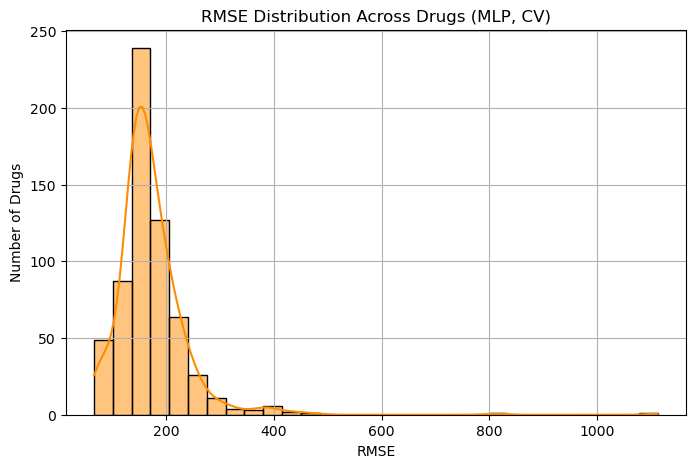

In [18]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse_mean"], kde=True, bins=30, color="darkorange")
plt.title("RMSE Distribution Across Drugs (MLP, CV)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()

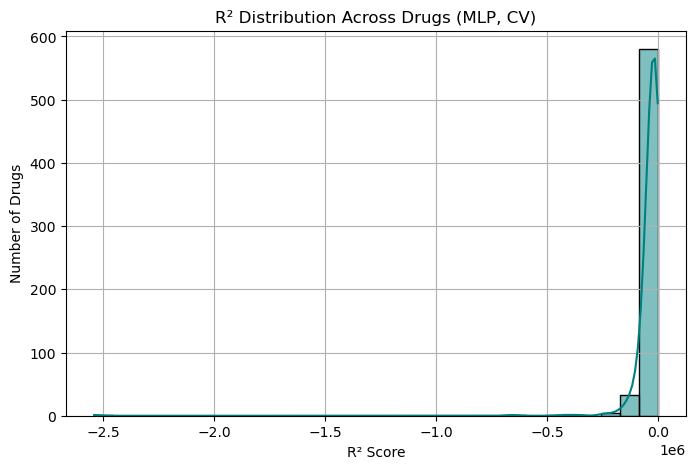

In [19]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_mean"], kde=True, bins=30, color="teal")
plt.title("R² Distribution Across Drugs (MLP, CV)")
plt.xlabel("R² Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()